In [43]:
# Load data
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import os
import logging
import json
import random

import numpy as np
import json
from tqdm.notebook import tqdm

# Load imagenet


# Path to your imagenet_class.json file
json_file_path = '/home/mila/s/sonia.joseph/ViT-Planetarium/my_draft/test_nbs/imagenet_class_index.json'
imagenet_path = '/network/datasets/imagenet.var/imagenet_torchvision/val/'

# Get class names
# imagenet_class_nums = np.arange(0, 1000, 1)
# imagenet_class_names = ["{}".format(get_class_name(i)) for i in imagenet_class_nums]

# Set the seed. You don't need indices if data is loaded in same order every time.
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# # Load the ImageNet dataset
imagenet_data = datasets.ImageFolder(imagenet_path, transform=data_transforms)


In [44]:
import pandas as pd
import os

layer_num = 7

save_path = f'/network/scratch/s/sonia.joseph/clip_mechinterp/tinyclip/mini_dataset/'
file_name = f'mlp_fc1_{layer_num}.npz'

loaded = pd.read_parquet(os.path.join(save_path, file_name))


In [45]:
# Load imagenet


# Path to your imagenet_class.json file
json_file_path = '/home/mila/s/sonia.joseph/ViT-Planetarium/my_draft/test_nbs/imagenet_class_index.json'
imagenet_path = '/network/datasets/imagenet.var/imagenet_torchvision/val/'

# Load the JSON file into a Python dictionary
with open(json_file_path, 'r') as file:
    num_to_word_dict = json.load(file)

# Create a reverse dictionary for word to number mapping
word_to_num_dict = {}
for num, words in num_to_word_dict.items():
    for word in words:  # Assuming each entry in num_to_word_dict is a list of words
        word_to_num_dict[word] = num

# Function to get the class name from a label
def get_class_name(label):
    # Assuming the label maps to a list of class names
    return num_to_word_dict.get(str(label), ["Unknown label"])[1]

# Function to get the label from a class name
def get_label(class_name):
    return word_to_num_dict.get(class_name, "Unknown class name")

# Get class names
imagenet_class_nums = np.arange(0, 1000, 1)
imagenet_class_names = ["{}".format(get_class_name(i)) for i in imagenet_class_nums]

# Set the seed. You don't need indices if data is loaded in same order every time.
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Function to load images based on saved order
def load_images_in_order(indices_path, imagenet_dataset):
    indices = np.load(indices_path)
    subset_dataset = Subset(imagenet_dataset, indices)
    data_loader = DataLoader(subset_dataset, batch_size=1)
    return data_loader

# Load the ImageNet dataset
batch_size = 1
imagenet_data = datasets.ImageFolder(imagenet_path, transform=data_transforms)
data_loader = load_images_in_order('imagenet_sample_indices.npy', imagenet_data)


In [46]:
# You need to 
# a) isolate the CLIP attention head and 
# b) get the intermediate activations of the fc2 layer, not fc1 
# c) well, you could actually ablate the fc1 layer and see the effect on the patch prediction downstream
# 

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


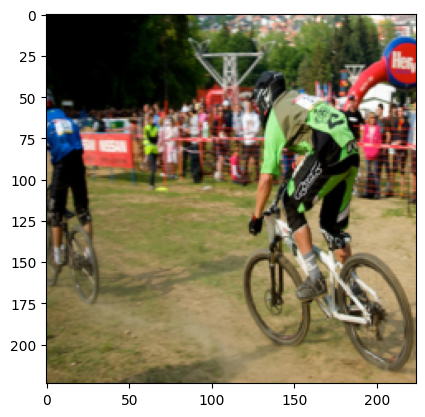

In [62]:
# Get CLIP 
from PIL import Image
import requests
import matplotlib.pyplot as plt

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("wkcn/TinyCLIP-ViT-8M-16-Text-3M-YFCC15M")
processor = CLIPProcessor.from_pretrained("wkcn/TinyCLIP-ViT-8M-16-Text-3M-YFCC15M", do_rescale=False) # Make sure the do_rescale is false for pytorch datasets

images, labels = next(iter(data_loader))

idx = 0

imagenet_class_names.extend(['wheel', 'green jacket', 'biker', 'red fence', 'woods', 'ground', 'patch of dirt', 'shorts'])
imagenet_class_names.extend([ "bicycle wheel", "tire", "spoke", "bicycle tire", "automotive tire", "bicycle part", "wheel", "rim", "vehicle", "bicycle", "groupset", "mountain bike", "auto part", "bicycle drivetrain part", "automotive wheel system" ])
inputs = processor(text=imagenet_class_names, images=images, return_tensors="pt", padding=True)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
# predicted_class = imagenet_class_names[probs.argmax(dim=1)]
predicted_indices = probs.argmax(dim=1)

plt.imshow(images[0].permute(1, 2, 0))
# plt.title(f"Predicted: {get_class_name(predicted_indices[idx].item())}. True: {get_class_name(labels[idx].item())}")

## Run linear probe

In [48]:
model.vision_model

CLIPVisionTransformer(
  (embeddings): CLIPVisionEmbeddings(
    (patch_embedding): Conv2d(3, 256, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (position_embedding): Embedding(197, 256)
  )
  (pre_layrnorm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (encoder): CLIPEncoder(
    (layers): ModuleList(
      (0): CLIPEncoderLayer(
        (self_attn): CLIPAttention(
          (k_proj): Linear(in_features=256, out_features=256, bias=True)
          (v_proj): Linear(in_features=256, out_features=256, bias=True)
          (q_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (layer_norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): CLIPMLP(
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=256, out_features=1024, bias=True)
          (fc2): Linear(in_features=1024, out_features=256, bias=True)
        )
        (l

In [49]:

# Hook function to capture output of each layer
def get_activations(name, activations):
    def hook(model, input, output):
        activations[name] = output
    return hook



In [64]:
import torch


# Assuming 'model' is your CLIP model
activations = {}
hooks = []

for layer_idx, layer in enumerate(model.vision_model.encoder.layers):
   for submodule_name, submodule in layer.named_children():
        # Create a unique name for each submodule
        name = f"layer_{layer_idx}_{submodule_name}"
        hook = submodule.register_forward_hook(get_activations(name, activations))
        hooks.append(hook)
    
hook = model.vision_model.post_layernorm.register_forward_hook(get_activations("post_layernorm", activations))
hooks.append(hook)
   
# Run a forward pass with your data
# Replace 'input_data' with your actual input tensor
output = model(**inputs)

# Now 'activations' will have the outputs of each layer
# ... (use the activations for your purpose)

# Detach the hooks after use
for hook in hooks:
    hook.remove()


In [65]:
activations.keys()

dict_keys(['layer_0_layer_norm1', 'layer_0_self_attn', 'layer_0_layer_norm2', 'layer_0_mlp', 'layer_1_layer_norm1', 'layer_1_self_attn', 'layer_1_layer_norm2', 'layer_1_mlp', 'layer_2_layer_norm1', 'layer_2_self_attn', 'layer_2_layer_norm2', 'layer_2_mlp', 'layer_3_layer_norm1', 'layer_3_self_attn', 'layer_3_layer_norm2', 'layer_3_mlp', 'layer_4_layer_norm1', 'layer_4_self_attn', 'layer_4_layer_norm2', 'layer_4_mlp', 'layer_5_layer_norm1', 'layer_5_self_attn', 'layer_5_layer_norm2', 'layer_5_mlp', 'layer_6_layer_norm1', 'layer_6_self_attn', 'layer_6_layer_norm2', 'layer_6_mlp', 'layer_7_layer_norm1', 'layer_7_self_attn', 'layer_7_layer_norm2', 'layer_7_mlp', 'layer_8_layer_norm1', 'layer_8_self_attn', 'layer_8_layer_norm2', 'layer_8_mlp', 'layer_9_layer_norm1', 'layer_9_self_attn', 'layer_9_layer_norm2', 'layer_9_mlp', 'post_layernorm'])

In [72]:
# Feed MLP layers into CLIP encoder

act = activations['layer_1_mlp']
# Get CLIP final head
vis_emb = model.visual_projection(act)

In [73]:
# Get original text similarity score
text_embeddings = outputs['text_embeds']

In [74]:
print(text_embeddings.shape)
print(vis_emb.shape)

torch.Size([1077, 512])
torch.Size([1, 197, 512])


In [75]:
import torch
import torch.nn.functional as F

# Assuming 'image_patches' is your image patch embeddings tensor of size [1, 197, 512]
# And 'text_embeddings' is your text embeddings tensor of size [1000, 512]
image_patches = vis_emb.squeeze(0)  # Now it's [197, 512]


# # Normalize the embeddings
# norm_image_patches = F.normalize(image_patches, p=2, dim=1)
# norm_text_embeddings = F.normalize(text_embeddings, p=2, dim=1)

# Compute cosine similarities
# The shape of 'cosine_sim' will be [197, 1000], representing the similarity 
# between each image patch and each text embedding
cosine_sim = torch.matmul(image_patches, text_embeddings.T)
probs = cosine_sim.softmax(dim=1) # we can take the softmax to get the label probabilities
pred_labels = probs.argmax(dim=1)
# Now, 'cosine_sim[i, j]' is the cosine similarity between the i-th image patch and the j-th text embedding


In [76]:
# I will use Python to overlay the given labels on an image, simulating a grid of 196 patches.
# For simplicity, let's assume the image is to be divided into a 14x14 grid (since 14*14 = 196).
# The labels will be overlaid on the corresponding patches.

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

# Load the image
# image_path = '/mnt/data/Screen Shot 2023-12-25 at 11.59.08 PM.png'
# image = Image.open(image_path)
image_array = images[0].permute(1, 2, 0).numpy()

# Define the grid size and labels
grid_size = (14, 14) # Since 14*14 = 196

# Calculate the patch size
patch_width = image_array.shape[1] // grid_size[1]
patch_height = image_array.shape[0] // grid_size[0]

# Create a figure and axis to plot the image
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(image_array)

# Function to get the patch position
def get_patch_position(index, grid_size, patch_width, patch_height):
    row = index // grid_size[1]
    col = index % grid_size[1]
    return col * patch_width, row * patch_height

# Overlay labels on the image
for i, label in enumerate(imagenet_class_names):
    x, y = get_patch_position(i, grid_size, patch_width, patch_height)
    rect = patches.Rectangle((x, y), patch_width, patch_height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.text(x, y, label, color='white', fontsize=8, ha='center', va='center')

# Remove axis for clarity
plt.axis('off')
plt.tight_layout()

# Save the resulting image
# output_path = '/mnt/data/annotated_image.png'
# plt.savefig(output_path)
plt.show()

# Return the path to the annotated image
# output_path


/home/mila/s/sonia.joseph/ViT-Planetarium/env/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


KeyboardInterrupt: 

In [ ]:
get_class_name(labels[0].item())

'mountain_bike'

In [ ]:
len(imagenet_class_names)

1008

In [77]:
# print("real class is ", get_class_name(labels[0].item()))
patch_labels = []
for idx, l in enumerate(pred_labels):
    print(idx, imagenet_class_names[l])
    patch_labels.append(imagenet_class_names[l])

0 hartebeest
1 hartebeest
2 hartebeest
3 hartebeest
4 Tibetan_mastiff
5 red-breasted_merganser
6 hartebeest
7 hartebeest
8 African_chameleon
9 groupset
10 hartebeest
11 hartebeest
12 agaric
13 hartebeest
14 sulphur-crested_cockatoo
15 hartebeest
16 hartebeest
17 hartebeest
18 hartebeest
19 hartebeest
20 hartebeest
21 hartebeest
22 hartebeest
23 hartebeest
24 hartebeest
25 hartebeest
26 hartebeest
27 groupset
28 groupset
29 hartebeest
30 hartebeest
31 hartebeest
32 hartebeest
33 hartebeest
34 groupset
35 Arabian_camel
36 Staffordshire_bullterrier
37 hartebeest
38 groupset
39 banded_gecko
40 groupset
41 groupset
42 hartebeest
43 hartebeest
44 hartebeest
45 hartebeest
46 hartebeest
47 hartebeest
48 groupset
49 African_chameleon
50 African_chameleon
51 hartebeest
52 Arabian_camel
53 hartebeest
54 Arabian_camel
55 African_chameleon
56 Arabian_camel
57 hartebeest
58 hartebeest
59 tiger_beetle
60 hartebeest
61 Gila_monster
62 tennis_ball
63 groupset
64 Staffordshire_bullterrier
65 hartebeest


In [ ]:
import gradio as gr
import numpy as np
from PIL import Image

# Load the image

image_array = np.array(images[0].permute(1, 2, 0))

# Define the grid size and labels
grid_size = (14, 14) # Since 14*14 = 196
labels = [
    "unicycle", "goldfinch", "goldfinch", "bee_eater", "forklift",
    # ... (complete the list as needed)
]

# Calculate the patch size
patch_width = image_array.shape[1] // grid_size[1]
patch_height = image_array.shape[0] // grid_size[0]

# Function to get the label for the patch based on the click position
def get_label_for_patch(coords):
    if coords is None:  # If no click, return nothing
        return ""
    x, y = coords
    col = int(x // patch_width)
    row = int(y // patch_height)
    index = row * grid_size[1] + col
    return labels[index % len(labels)]  # Use modulo in case there are fewer labels than patches

# Create the Gradio interface
iface = gr.Interface(
    fn=get_label_for_patch,
    inputs=gr.inputs.Image(shape=(images.shape[0], images.shape[1]), image_mode='RGB', source="canvas"),
    outputs="label",
    live=True
)

# Run the interface
iface.launch(share=True)


/home/mila/s/sonia.joseph/ViT-Planetarium/env/lib/python3.7/site-packages/gradio/inputs.py:260: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/home/mila/s/sonia.joseph/ViT-Planetarium/env/lib/python3.7/site-packages/gradio/inputs.py:270: UserWarning: `optional` parameter is deprecated, and it has no effect
  optional=optional,


Running on local URL:  http://127.0.0.1:7861
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Running on public URL: https://4b6f5afe4012cb5791.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
!pip install gradio

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Obtaining dependency information for gradio from https://files.pythonhosted.org/packages/29/e9/592634ca97719735608b0cf92b05e5061cfaaa0e77d0c1ed24017273b525/gradio-3.34.0-py3-none-any.whl.metadata
  Obtaining dependency information for aiofiles from https://files.pythonhosted.org/packages/c5/19/5af6804c4cc0fed83f47bff6e413a98a36618e7d40185cd36e69737f3b0e/aiofiles-23.2.1-py3-none-any.whl.metadata
  Obtaining dependency information for altair>=4.2.0 from https://files.pythonhosted.org/packages/b2/20/5c3b89d6f8d9938325a9330793438389e0dc94c34d921f6da35ec62095f3/altair-5.0.1-py3-none-any.whl.metadata
  Obtaining dependency information for fastapi from https://files.python